Model Can Walk
==============



## Goal



The goal of this notebook is to make plots for Figure 2 of the paper. Namely:

-   An example trajectory
-   Phase angle plot comparisons
-   Angle error
-   Phase coupling within a leg
-   Phase coupling across legs
-   Step frequency distributions
-   Demo videos

The network should be set up so that running it from top to bottom makes all the figure sublayouts.



## Setup



In [1]:
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import matplotlib.pyplot as plt
import os
from tqdm import tqdm, trange
import pandas as pd
from scipy import signal

In [1]:
import sys
project_path = "/home/pierre/research/tuthill/layered-walking"
sys.path.append(project_path)
from tools.angle_functions import anglesTG as angle_names_1leg
from tools.angle_functions import legs
from tools.angle_functions import make_fly_video, angles_to_pose_names
from tools.trajgen_tools import WalkingData

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = (7.5, 2)

In [1]:
xvals = np.linspace(-np.pi, np.pi)
def get_phase(ang):
    m = np.median(ang, axis=0)
    s = np.std(ang, axis=0)
    s[s == 0] = 1
    dm = (ang - m) / s
    phase = np.arctan2(-dm[:,1], dm[:,0])
    return phase

def phase_align_poly(ang, extra=None, order=5):
    topredict = ang
    if extra is not None:
        topredict = np.hstack([ang, extra])
    means = np.full((len(xvals), topredict.shape[1]), np.nan)
    stds = np.full((len(xvals), topredict.shape[1]), np.nan)
    if len(ang) < 50: # not enough data
        return means, stds
    phase = get_phase(ang)
    # pcs = np.vstack([np.cos(phase), np.sin(phase)]).T
    b = np.vstack([np.cos(i * phase + j) for i in range(order) for j in [0, np.pi/2]]).T
    xcs = np.vstack([np.cos(i * xvals + j) for i in range(order) for j in [0, np.pi/2]]).T
    for i in range(topredict.shape[1]):
        cc = np.isfinite(topredict[:,i])
        model = sm.OLS(topredict[cc,i], b[cc]).fit()
        means[:,i] = model.predict(xcs)
        s, upper,lower = wls_prediction_std(model, xcs)
        stds[:,i] = s
    return means, stds

In [1]:
# list(d.keys())

In [1]:
fname = os.path.join(project_path, 'output', 'control_stats_v13.npz')
d = np.load(fname, allow_pickle=True)

conditions = d['conditions'][()]
angles = d['angleTG']
derivs = d['drvTG']
poses = d['pose_3d']
accels = signal.savgol_filter(derivs, 5, 2, deriv=1, axis=3)


speeds = np.array([x['context'] for x in conditions])

In [1]:
poses.shape

| 500 | 600 | 6 | 5 | 3 |

In [1]:
fname = '/home/pierre/data/tuthill/models/models_sls/walk_sls_legs_13.pickle'
wd = WalkingData(fname)

In [1]:
wd.bout_context

array([[ 9.968394 , -0.2343701,  2.8402553],
       [ 5.0455656,  8.416804 , -0.6643358],
       [ 8.86242  ,  8.355217 , -1.4570035],
       ...,
       [ 9.824624 ,  3.8363965,  2.475409 ],
       [13.015    , -0.6182214,  1.8810371],
       [ 6.7187276, -3.0979152,  2.84063  ]], dtype=float32)

In [1]:
fancy_angle_names = {
    'C_flex': 'femur-tibia\nflexion',
    'A_rot': 'coxa\nrotation',
    'A_abduct': 'body-coxa\nflexion',
    'B_flex': 'coxa-femur\nflexion',
    'B_rot': 'femur\nrotation'
}

## Example time series



For the figure part A, we&rsquo;d like to have multiple example angles. Perhaps R1 femur-tibia flexion would be good to show, but also L2 femur rotation?
I&rsquo;d like to have multiple traces for each angle, perhaps we could show with forward, rotation, and sideslip?

In this code, we could also make a supplementary figure with a more complete set of angles.



### Real tracking



Parameters for both angles



In [1]:
plot_speeds = [[8, 0, 0], [12, 0, 0], [16, 0, 0]]

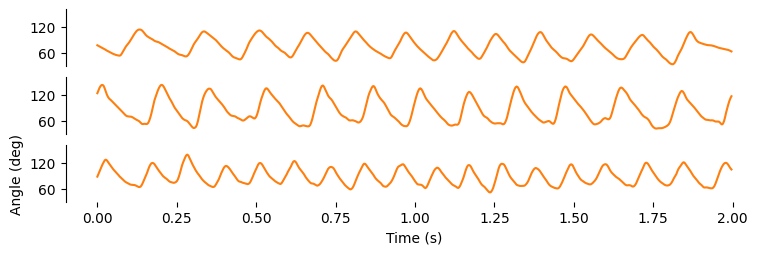

In [1]:
angname = 'C_flex'
leg = 'R1'
ix_ang = angle_names_1leg.index(angname)
ix_leg = legs.index(leg)

plt.figure(figsize=(9, 2.5))
for i in range(len(plot_speeds)):
    plt.subplot(3, 1, i+1)
    ww = wd.get_bout(plot_speeds[i], offset=6)
    ang = ww['angles'][leg][:, ix_ang]
    t = np.arange(len(ang))/300.0
    plt.plot(t, ang, color="#FF7F0E")
    plt.ylim(30, 160)
    plt.yticks([60, 120])
    if i != 2:
        plt.xticks(ticks=[])

sns.despine(bottom=True)

plt.ylabel("Angle (deg)")
plt.xlabel("Time (s)")
plt.savefig('plots/fig2A_trace_real_{}{}.pdf'.format(leg, angname), bbox_inches = "tight")

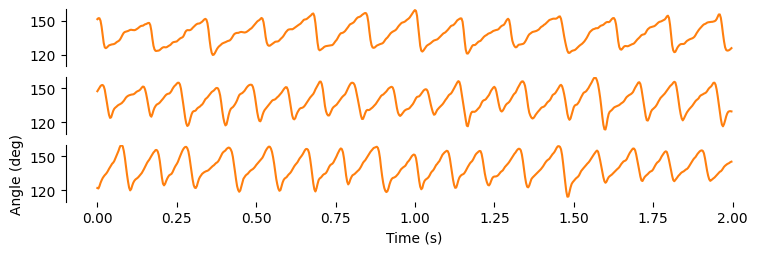

In [1]:
angname = 'B_rot'
leg = 'L2'
ix_ang = angle_names_1leg.index(angname)
ix_leg = legs.index(leg)

plt.figure(figsize=(9, 2.5))
for i in range(len(plot_speeds)):
    plt.subplot(3, 1, i+1)
    ww = wd.get_bout(plot_speeds[i], offset=2)
    ang = ww['angles'][leg][:, ix_ang].copy()
    t = np.arange(len(ang))/300.0
    ang[ang > 50] -= 360
    ang += 360
    plt.plot(t, ang, color="#FF7F0E")
    plt.ylim(110, 160)
    plt.yticks([120, 150])
    if i != 2:
        plt.xticks(ticks=[])

sns.despine(bottom=True)

plt.ylabel("Angle (deg)")
plt.xlabel("Time (s)")
plt.savefig('plots/fig2A_trace_real_{}{}.pdf'.format(leg, angname), bbox_inches = "tight")

### Simulated plots



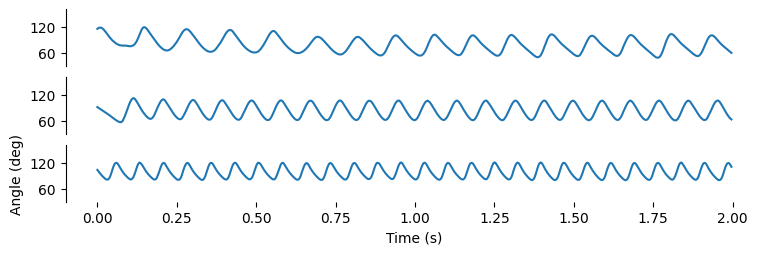

In [1]:
angname = 'C_flex'
leg = 'R1'
ix_ang = angle_names_1leg.index(angname)
ix_leg = legs.index(leg)

plt.figure(figsize=(9, 2.5))
for i in range(len(plot_speeds)):
    plt.subplot(3, 1, i+1)
    ixs = np.where(np.all(speeds == plot_speeds[i], axis=1))[0]
    ix_bout = ixs[2]
    ang = angles[ix_bout, ix_leg, ix_ang, :]
    t = np.arange(len(ang))/300.0
    plt.plot(t, ang)
    plt.ylim(30, 160)
    plt.yticks([60, 120])
    if i != 2:
        plt.xticks(ticks=[])

sns.despine(bottom=True)

plt.ylabel("Angle (deg)")
plt.xlabel("Time (s)")

plt.savefig('plots/fig2A_trace_simulated_{}{}.pdf'.format(leg, angname), bbox_inches = "tight")

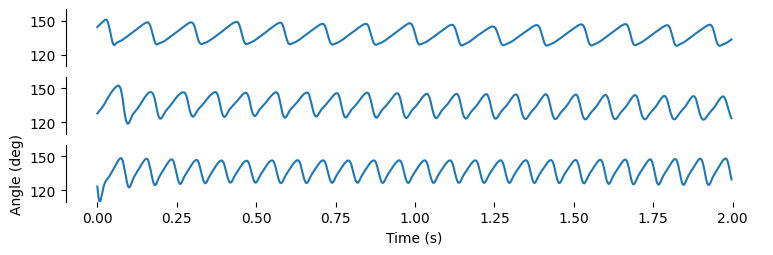

In [1]:
angname = 'B_rot'
leg = 'L2'
ix_ang = angle_names_1leg.index(angname)
ix_leg = legs.index(leg)

plt.figure(figsize=(9, 2.5))
for i in range(len(plot_speeds)):
    plt.subplot(3, 1, i+1)
    ixs = np.where(np.all(speeds == plot_speeds[i], axis=1))[0]
    ix_bout = ixs[0]
    ang = angles[ix_bout, ix_leg, ix_ang, :]
    t = np.arange(len(ang))/300.0
    plt.plot(t, ang)
    plt.ylim(110, 160)
    plt.yticks([120, 150])
    if i != 2:
        plt.xticks(ticks=[])

sns.despine(bottom=True)

plt.ylabel("Angle (deg)")
plt.xlabel("Time (s)")

plt.savefig('plots/fig2A_trace_simulated_{}{}.pdf'.format(leg, angname), bbox_inches = "tight")

## Phase plots



Load the simulated data



In [1]:
ds = []
for i in trange(len(speeds), ncols=70):
    for ix_leg, leg in enumerate(legs):
        for ix_ang, angname in enumerate(angle_names_1leg):
            forward, rot, side = speeds[i]
            x = np.vstack([angles[i, ix_leg, ix_ang, :],
                           derivs[i, ix_leg, ix_ang, :]]).T
            c = np.all(np.isfinite(x), axis=1)
            x = x[c]
            means, stds = phase_align_poly(
                x, extra=accels[i, ix_leg, ix_ang, :, None])
            d = pd.DataFrame(np.hstack([xvals[:,None],means]),
                             columns=['phase', 'angle', 'deriv', 'accel'])
            d['speed_forward'] = forward
            d['speed_rotation'] = rot
            d['speed_side'] = side
            d['angle_name'] = angname
            d['leg'] = leg
            d['type'] = 'simulated'
            ds.append(d)
allangf = pd.concat(ds).reset_index(drop=True)

100%|███████████████████████████████| 500/500 [00:58<00:00,  8.61it/s]

Load the real data



In [1]:
ds = []
bnums = wd._get_minlen_bnums(400)
for i in trange(len(bnums), ncols=70):
    bnum = bnums[i]
    ww = wd.get_bnum(bnum)
    mean_speed = np.mean(ww['contexts'], axis=0)
    forward, rot, side = mean_speed
    for ix_leg, leg in enumerate(legs):
        for ix_ang, angname in enumerate(angle_names_1leg):
            angs = ww['angles'][leg][:, ix_ang]
            drvs = ww['derivatives'][leg][:, ix_ang]
            acls = signal.savgol_filter(drvs, 5, 2, deriv=1)
            x = np.vstack([angs, drvs]).T
            c = np.all(np.isfinite(x), axis=1)
            x = x[c]
            means, stds = phase_align_poly(
                x, extra=acls[:,None])
            d = pd.DataFrame(np.hstack([xvals[:,None],means]),
                             columns=['phase', 'angle', 'deriv', 'accel'])
            d['speed_forward_raw'] = forward
            d['speed_rotation_raw'] = rot
            d['speed_side_raw'] = side
            d['angle_name'] = angname
            d['leg'] = leg
            d['bnum'] = bnum
            d['type'] = 'real'
            ds.append(d)
realangf = pd.concat(ds).reset_index(drop=True)

realangf['speed_forward'] = ((realangf['speed_forward_raw'] + 2) // 4) * 4
realangf['speed_rotation'] = ((realangf['speed_rotation_raw'] + 2) // 4) * 4
realangf['speed_side'] = ((realangf['speed_side_raw'] + 1) // 2) * 2

realangf['speed_forward'] = realangf['speed_forward'].astype('int')
realangf['speed_rotation'] = realangf['speed_rotation'].astype('int')
realangf['speed_side'] = realangf['speed_side'].astype('int')

100%|███████████████████████████████| 171/171 [00:20<00:00,  8.50it/s]
:

In [1]:
fullangf = pd.concat([allangf, realangf]).reset_index(drop=True)

In [1]:
fullangf['deriv_units'] = fullangf['deriv'] * 300.0
fullangf['accel_units'] = fullangf['accel'] * 300.0 * 300.0

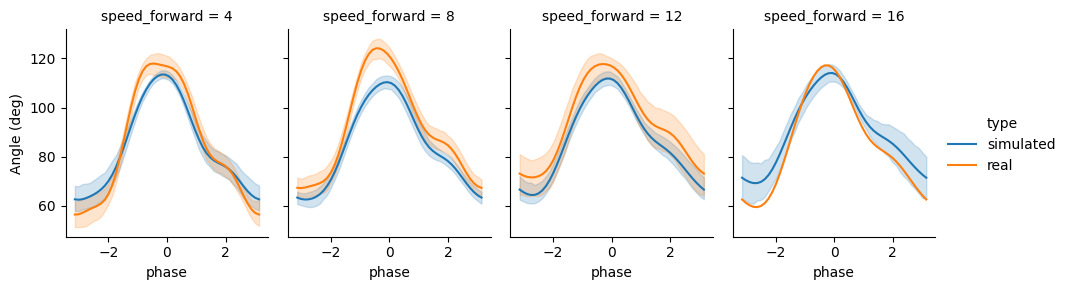

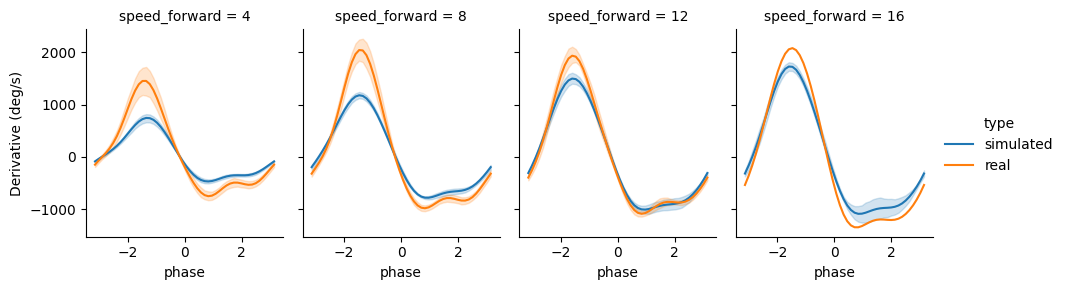

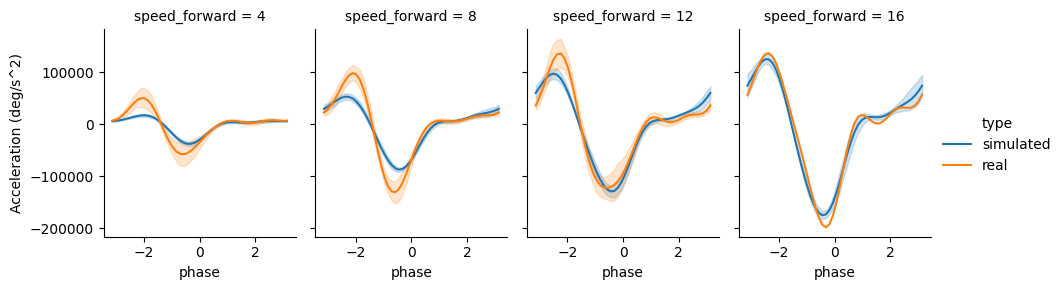

In [1]:
leg = 'R1'
angname = 'C_flex'

dd = fullangf
c = (dd['speed_side'].abs() <= 3) & (dd['speed_rotation'].abs() <= 3) \
    & (dd['speed_forward'] > 1) \
    & (dd['angle_name'] == angname) & (dd['leg'] == leg)
g = sns.relplot(data=dd[c], x="phase", y="angle", hue="type",
                estimator=np.mean, err_style='band', ci=95,
                col="speed_forward", kind="line", height=3, aspect=0.8)
g.set(ylabel="Angle (deg)")
plt.savefig('plots/fig2B_phase_angle_{}{}.pdf'.format(leg, angname), bbox_inches = "tight")

c = (dd['speed_side'].abs() <= 3) & (dd['speed_rotation'].abs() <= 3) \
    & (dd['speed_forward'] > 1) \
    & (dd['angle_name'] == angname) & (dd['leg'] == leg)
g = sns.relplot(data=dd[c], x="phase", y="deriv_units", hue="type",
                estimator=np.mean, err_style='band', ci=95,
                col="speed_forward", kind="line", height=3, aspect=0.8)
g.set(ylabel="Derivative (deg/s)")
plt.savefig('plots/fig2B_phase_deriv_{}{}.pdf'.format(leg, angname), bbox_inches = "tight")

c = (dd['speed_side'].abs() <= 3) & (dd['speed_rotation'].abs() <= 3) \
    & (dd['speed_forward'] > 1) \
    & (dd['angle_name'] == angname) & (dd['leg'] == leg)
g = sns.relplot(data=dd[c], x="phase", y="accel_units", hue="type",
                estimator=np.mean, err_style='band', ci=95,
                col="speed_forward", kind="line", height=3, aspect=0.8)
g.set(ylabel="Acceleration (deg/s^2)")
plt.savefig('plots/fig2B_phase_accel_{}{}.pdf'.format(leg, angname), bbox_inches = "tight")

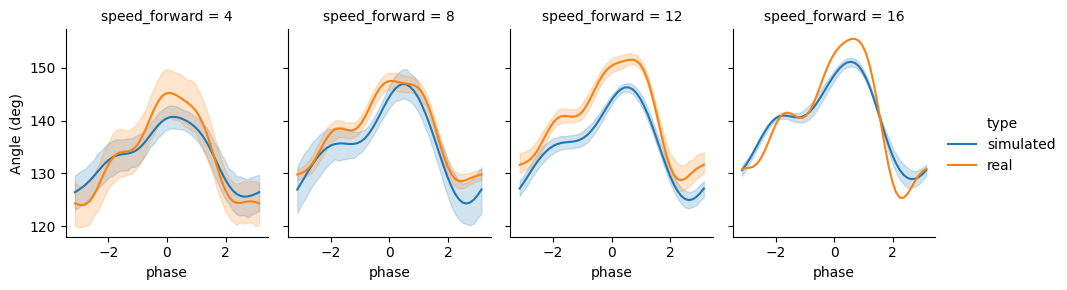

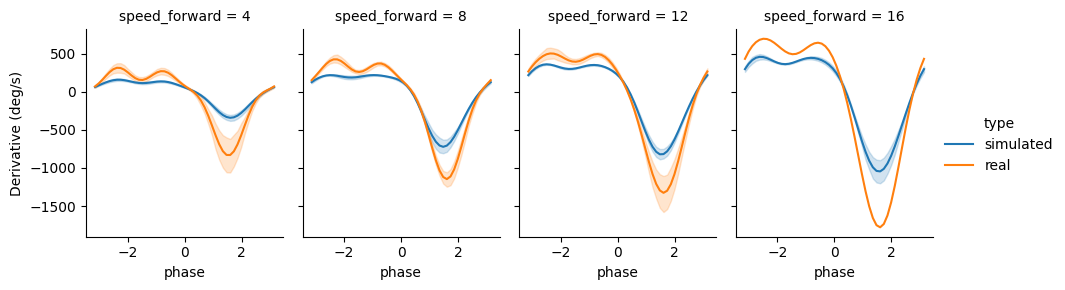

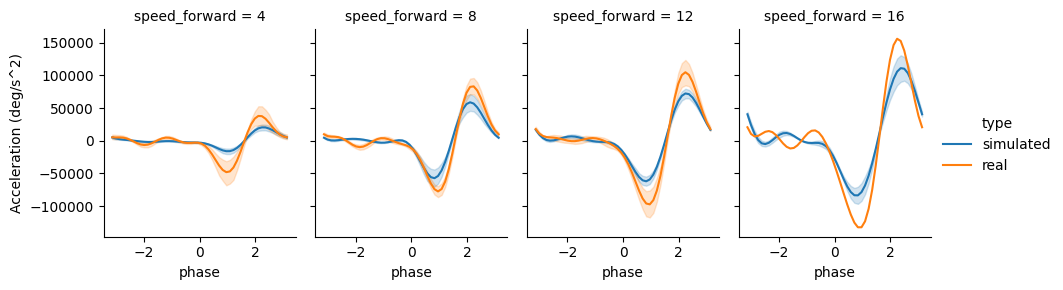

In [1]:
leg = 'L2'
angname = 'B_rot'

dd = fullangf
c = (dd['speed_side'].abs() <= 3) & (dd['speed_rotation'].abs() <= 3) \
    & (dd['speed_forward'] > 1) \
    & (dd['angle_name'] == angname) & (dd['leg'] == leg)
g = sns.relplot(data=dd[c], x="phase", y="angle", hue="type",
                estimator=np.mean, err_style='band', ci=95,
                col="speed_forward", kind="line", height=3, aspect=0.8)
g.set(ylabel="Angle (deg)")
plt.savefig('plots/fig2B_phase_angle_{}{}.pdf'.format(leg, angname), bbox_inches = "tight")

c = (dd['speed_side'].abs() <= 3) & (dd['speed_rotation'].abs() <= 3) \
    & (dd['speed_forward'] > 1) \
    & (dd['angle_name'] == angname) & (dd['leg'] == leg)
g = sns.relplot(data=dd[c], x="phase", y="deriv_units", hue="type",
                estimator=np.mean, err_style='band', ci=95,
                col="speed_forward", kind="line", height=3, aspect=0.8)
g.set(ylabel="Derivative (deg/s)")
plt.savefig('plots/fig2B_phase_deriv_{}{}.pdf'.format(leg, angname), bbox_inches = "tight")

c = (dd['speed_side'].abs() <= 3) & (dd['speed_rotation'].abs() <= 3) \
    & (dd['speed_forward'] > 1) \
    & (dd['angle_name'] == angname) & (dd['leg'] == leg)
g = sns.relplot(data=dd[c], x="phase", y="accel_units", hue="type",
                estimator=np.mean, err_style='band', ci=95,
                col="speed_forward", kind="line", height=3, aspect=0.8)
g.set(ylabel="Acceleration (deg/s^2)")
plt.savefig('plots/fig2B_phase_accel_{}{}.pdf'.format(leg, angname), bbox_inches = "tight")

## Angle errors



In [1]:
def circular_mean(x):
    return np.degrees(np.angle(np.nanmean(np.exp(1j * np.radians(x)))))

In [1]:
columns = ['leg', 'speed_forward', 'speed_rotation', 'speed_side', 'angle_name', 'phase']

ds = []
for var in ['angle', 'deriv', 'accel']:
    print(var)
    if var == 'angle':
        mean_fun = circular_mean
    else:
        mean_fun = np.nanmean
    sd = allangf.groupby(columns)[var].agg(mean_fun)
    rd = realangf.groupby(columns)[var].agg(mean_fun)
    out = sd - rd
    errors = out.reset_index().groupby(columns[:-1])[var]\
                              .agg(lambda x: np.abs(mean_fun(np.abs(x))))

    erange = rd.reset_index().groupby(columns[:-1])[var]\
                             .agg(lambda x: np.max(x) - np.min(x))

    percent_errors = (errors / erange) * 100.0

    errors = errors.reset_index()
    errors[var+'_percent'] = percent_errors.reset_index()[var]
    errors = errors[~errors[var].isnull()]
    ds.append(errors)

angle_errors = pd.merge(pd.merge(ds[0], ds[1]), ds[2])

fancy_angle_names = {
    'C_flex': 'femur-tibia\nflexion',
    'A_rot': 'coxa\nrotation',
    'A_abduct': 'body-coxa\nflexion',
    'B_flex': 'coxa-femur\nflexion',
    'B_rot': 'femur\nrotation'
}
angle_errors['fancy_angle_name'] = [fancy_angle_names[x] for x in angle_errors['angle_name']]

angle_errors['deriv_units'] = angle_errors['deriv'] * 300.0
angle_errors['accel_units'] = angle_errors['accel'] * 300.0 * 300.0

angle
/tmp/ipykernel_675863/855530367.py:2: RuntimeWarning: Mean of empty slice
  return np.degrees(np.angle(np.nanmean(np.exp(1j * np.radians(x)))))
deriv
/tmp/ipykernel_675863/1432084253.py:14: RuntimeWarning: Mean of empty slice
  .agg(lambda x: np.abs(mean_fun(np.abs(x))))
accel
/tmp/ipykernel_675863/1432084253.py:14: RuntimeWarning: Mean of empty slice
  .agg(lambda x: np.abs(mean_fun(np.abs(x))))

In [1]:
plt.figure(figsize=(5, 4))
plt.subplot(1, 3, 1)
g = sns.violinplot(y='fancy_angle_name', x='angle', data=angle_errors,
                   hue=True, hue_order=[True, False], split=True, orient='h', color='black')
g.set(ylabel='Angle', xlabel='Angle\nerror (deg)')
g.legend_ = None

plt.subplot(1, 3, 2)
g = sns.violinplot(y='fancy_angle_name', x='deriv_units', data=angle_errors,
                   hue=True, hue_order=[True, False], split=True, orient='h', color='black')
g.set(ylabel='', xlabel='Derivative\nerror (deg/s)', yticklabels=[])
g.legend_ = None

plt.subplot(1, 3, 3)
g = sns.violinplot(y='fancy_angle_name', x='accel_units', data=angle_errors,
                   hue=True, hue_order=[True, False], split=True, orient='h', color='black')
g.set(ylabel='', xlabel='Acceleration\nerror (deg/s^2)', yticklabels=[])
g.legend_ = None

plt.savefig('plots/fig2C_error_raw_horizontal.pdf', bbox_inches = "tight")

In [1]:
plt.figure(figsize=(6, 4))
ax = plt.subplot(2, 1, 1)
g = sns.violinplot(x='angle_name', y='angle', data=angle_errors, color='lightgray', cut=0)
g.set(ylabel='Angle error (deg)', xlabel='')
plt.axhline(5.9, linestyle='dotted', color='gray')
ax.set_xticklabels([])
g.legend_ = None

plt.subplot(2, 1, 2)
g = sns.violinplot(x='fancy_angle_name', y='deriv_units', data=angle_errors, color='lightgray', cut=0)
g.set(xlabel='Angle', ylabel='Derivative error (deg/s)')
# plt.axhline(5.9, linestyle='dotted', color='black')
g.legend_ = None

plt.savefig('plots/fig2C_error_raw_vertical.pdf', bbox_inches = "tight")

In [1]:
plt.figure(figsize=(2.5*3, 4))
plt.subplot(1, 3, 1)
g = sns.violinplot(y='fancy_angle_name', x='angle_percent', data=angle_errors, cut=0.2, bw=0.1,
                   hue=True, hue_order=[True, False], split=True, orient='h', color='black')
g.set(ylabel='Angle', xlabel='Angle\npercent error', xlim=(-1, 130))
g.legend_ = None

plt.subplot(1, 3, 2)
g = sns.violinplot(y='fancy_angle_name', x='deriv_percent', data=angle_errors, cut=1, bw=0.2,
                   hue=True, hue_order=[True, False], split=True, orient='h', color='black')
g.set(ylabel='', xlabel='Derivative\npercent error', yticklabels=[], xlim=(0, 50))
g.legend_ = None

plt.subplot(1, 3, 3)
g = sns.violinplot(y='fancy_angle_name', x='accel_percent', data=angle_errors, cut=1, bw=0.2,
                   hue=True, hue_order=[True, False], split=True, orient='h', color='black')
g.set(ylabel='', xlabel='Acceleration\npercent error', yticklabels=[], xlim=(0, 50))
g.legend_ = None

plt.savefig('plots/fig2C_error_percent.pdf', bbox_inches = "tight")

## Phase coupling within a leg - angles version



Here we make Figure 2D, which conveys the coupling with a single leg.
In the past, I have conveyed this by plotting each leg angle against the phase of a single joint.

I&rsquo;ll try to do this with one figure per leg. For T1 and T3, we can use femur-tibia flexion as phase. For T2, we can use femur-rotation.

Load the simulated data



In [1]:
cols = [x + '_' + y for x in angle_names_1leg
        for y in ['angle', 'deriv', 'accel']]
ds = []
for i in trange(len(speeds), ncols=70):
    for ix_leg, leg in enumerate(legs):
        if leg in ['L2', 'R2']:
            phaseang = 'B_rot'
        else:
            phaseang = 'C_flex'
        forward, rot, side = speeds[i]
        ix_ang_phase = angle_names_1leg.index(phaseang)
        x = np.vstack([angles[i, ix_leg, ix_ang_phase, :],
                       derivs[i, ix_leg, ix_ang_phase, :]]).T
        rest = []
        for ix_ang, angname in enumerate(angle_names_1leg):
            rest.append(angles[i, ix_leg, ix_ang, :])
            rest.append(derivs[i, ix_leg, ix_ang, :])
            rest.append(accels[i, ix_leg, ix_ang, :])
        rest = np.vstack(rest).T
        c = np.all(np.isfinite(rest), axis=1)
        x = x[c]
        rest = rest[c]
        means, stds = phase_align_poly(x, extra=rest)
        d = pd.DataFrame(np.hstack([xvals[:,None],means[:,2:]]),
                         columns=['phase'] + cols)
        d['speed_forward'] = forward
        d['speed_rotation'] = rot
        d['speed_side'] = side
        d['angle_name'] = angname
        d['leg'] = leg
        d['type'] = 'simulated'
        ds.append(d)
allangf_sync = pd.concat(ds).reset_index(drop=True)

Load the real data



In [1]:
cols = [x + '_' + y for x in angle_names_1leg
        for y in ['angle', 'deriv', 'accel']]
ds = []
bnums = wd._get_minlen_bnums(400)
for i in trange(len(bnums), ncols=70):
    bnum = bnums[i]
    ww = wd.get_bnum(bnum)
    mean_speed = np.mean(ww['contexts'], axis=0)
    forward, rot, side = mean_speed
    for ix_leg, leg in enumerate(legs):
        if leg in ['L2', 'R2']:
            phaseang = 'B_rot'
        else:
            phaseang = 'C_flex'
        ix_ang_phase = angle_names_1leg.index(phaseang)
        x = np.vstack([ww['angles'][leg][:, ix_ang_phase],
                       ww['derivatives'][leg][:, ix_ang_phase]]).T
        rest = []
        for ix_ang, angname in enumerate(angle_names_1leg):
            angs = ww['angles'][leg][:, ix_ang]
            drvs = ww['derivatives'][leg][:, ix_ang]
            acls = signal.savgol_filter(drvs, 5, 2, deriv=1)
            rest.append(angs)
            rest.append(drvs)
            rest.append(acls)
        rest = np.vstack(rest).T
        c = np.all(np.isfinite(rest), axis=1)
        means, stds = phase_align_poly(x, extra=rest)
        d = pd.DataFrame(np.hstack([xvals[:,None],means[:,2:]]),
                         columns=['phase'] + cols)
        d['speed_forward_raw'] = forward
        d['speed_rotation_raw'] = rot
        d['speed_side_raw'] = side
        d['angle_name'] = angname
        d['leg'] = leg
        d['bnum'] = bnum
        d['type'] = 'real'
        ds.append(d)
realangf_sync = pd.concat(ds).reset_index(drop=True)

realangf_sync['speed_forward'] = ((realangf_sync['speed_forward_raw'] + 2) // 4) * 4
realangf_sync['speed_rotation'] = ((realangf_sync['speed_rotation_raw'] + 2) // 4) * 4
realangf_sync['speed_side'] = ((realangf_sync['speed_side_raw'] + 1) // 2) * 2
realangf_sync['speed_forward'] = realangf_sync['speed_forward'].astype('int')
realangf_sync['speed_rotation'] = realangf_sync['speed_rotation'].astype('int')
realangf_sync['speed_side'] = realangf_sync['speed_side'].astype('int')

# [goto error]
  Input In [28]
    ds.append(d)
    ^
IndentationError: unexpected indent

In [1]:
fullangf_sync_raw = pd.concat([allangf_sync, realangf_sync]).reset_index(drop=True)

# [goto error]
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Input In [29], in <cell line: 1>()
----> 1 fullangf_sync_raw = pd.concat([allangf_sync, realangf_sync]).reset_index(drop=True)

NameError: name 'realangf_sync' is not defined

In [1]:
fullangf_sync_melt = pd.melt(
    fullangf_sync_raw,
    id_vars=['phase','speed_forward',
             'speed_rotation', 'speed_side', 'angle_name',
             'speed_forward_raw', 'speed_rotation_raw', 'speed_side_raw',
             'leg', 'type', 'bnum'])
fullangf_sync_melt['order'] = [x.split('_')[-1] for x in fullangf_sync_melt['variable']]

fullangf_sync = fullangf_sync_melt[fullangf_sync_melt['order'] == 'angle'].reset_index(drop=True)
fullangf_sync.loc[:,'angle_name'] = [x.replace('_angle', '') for x in fullangf_sync['variable']]
fullangf_sync.loc[:,'angle'] = fullangf_sync['value'].values
fullangf_sync.loc[:,'deriv'] = fullangf_sync_melt.loc[
    fullangf_sync_melt['order'] == 'deriv', 'value'].values
fullangf_sync.loc[:,'accel'] = fullangf_sync_melt.loc[
    fullangf_sync_melt['order'] == 'accel', 'value'].values

# [goto error]
#+begin_example
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Input In [30], in <cell line: 1>()
      1 fullangf_sync_melt = pd.melt(
----> 2     fullangf_sync_raw,
      3     id_vars=['phase','speed_forward',
      4              'speed_rotation', 'speed_side', 'angle_name',
      5              'speed_forward_raw', 'speed_rotation_raw', 'speed_side_raw',
      6              'leg', 'type', 'bnum'])
      7 fullangf_sync_melt['order'] = [x.split('_')[-1] for x in fullangf_sync_melt['variable']]
      9 fullangf_sync = fullangf_sync_melt[fullangf_sync_melt['order'] == 'angle'].reset_index(drop=True)

NameError: name 'fullangf_sync_raw' is not defined
#+end_example

In [1]:
fullangf_sync['fancy_angle_name'] = [fancy_angle_names[x] for x in fullangf_sync['angle_name']]

# [goto error]
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Input In [31], in <cell line: 1>()
----> 1 fullangf_sync['fancy_angle_name'] = [fancy_angle_names[x] for x in fullangf_sync['angle_name']]

NameError: name 'fullangf_sync' is not defined

In [1]:
# leg = 'L1'
dd = fullangf_sync
c = (dd['speed_side'].abs() <= 3) & (dd['speed_rotation'].abs() <= 3) \
    & (dd['speed_forward'] == 12)
g = sns.relplot(data=dd[c], x="phase", y="angle", hue="type",
                estimator=np.mean, err_style='band', ci=95,
                row='leg', col="fancy_angle_name", kind="line",
                height=2, aspect=0.8, facet_kws={'sharey': False, 'sharex': True})
g.axes[0][0].set_ylabel('angle')
g.set_titles("{row_name} {col_name}")

plt.savefig('plots/fig2D_coupling_perleg.pdf', bbox_inches = "tight")

# [goto error]
#+begin_example
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Input In [32], in <cell line: 2>()
      1 # leg = 'L1'
----> 2 dd = fullangf_sync
      3 c = (dd['speed_side'].abs() <= 3) & (dd['speed_rotation'].abs() <= 3) \
      4     & (dd['speed_forward'] == 12)
      5 g = sns.relplot(data=dd[c], x="phase", y="angle", hue="type",
      6                 estimator=np.mean, err_style='band', ci=95,
      7                 row='leg', col="fancy_angle_name", kind="line",
      8                 height=2, aspect=0.8, facet_kws={'sharey': False, 'sharex': True})

NameError: name 'fullangf_sync' is not defined
#+end_example

## Phase coupling within a leg - phase version



In [1]:
ds = []
for i in trange(len(speeds), ncols=70):
    forward, rot, side = speeds[i]
    d = pd.DataFrame()
    for ix_leg, leg in enumerate(legs):
        for ix_ang, angname in enumerate(angle_names_1leg):
            x = np.vstack([angles[i, ix_leg, ix_ang, :],
                           derivs[i, ix_leg, ix_ang, :]]).T
            phase = get_phase(x)
            key = leg + angname
            d[key] = phase
    d['speed_forward'] = forward
    d['speed_rotation'] = rot
    d['speed_side'] = side
    d['type'] = 'simulated'
    ds.append(d)
phases_byleg_sim = pd.concat(ds).reset_index(drop=True)

100%|██████████████████████████████| 500/500 [00:04<00:00, 103.98it/s]
:

In [1]:
ds = []
bnums = wd._get_minlen_bnums(400)
for i in trange(len(bnums), ncols=70):
    bnum = bnums[i]
    ww = wd.get_bnum(bnum)
    mean_speed = np.mean(ww['contexts'], axis=0)
    forward, rot, side = mean_speed
    d = pd.DataFrame()
    for ix_leg, leg in enumerate(legs):
        for ix_ang, angname in enumerate(angle_names_1leg):
            x = np.vstack([ww['angles'][leg][:, ix_ang],
                           ww['derivatives'][leg][:, ix_ang]]).T
            phase = get_phase(x)
            key = leg + angname
            d[key] = phase
    d['speed_forward'] = forward
    d['speed_rotation'] = rot
    d['speed_side'] = side
    d['type'] = 'real'
    ds.append(d)
phases_byleg_real = pd.concat(ds).reset_index(drop=True)

100%|███████████████████████████████| 171/171 [00:01<00:00, 96.07it/s]
:

In [1]:
phases_byleg = pd.concat([phases_byleg_sim, phases_byleg_real])

In [1]:
d = phases_byleg
fig, subplots = plt.subplots(6, 5, figsize=(9, 1.5*6))
for ix_leg, leg in enumerate(legs):
    if leg in ['L2', 'R2']:
        refname = 'B_rot'
    else:
        refname = 'C_flex'
    for ix_ang, angname in enumerate(sorted(angle_names_1leg)):
        ax = subplots[ix_leg][ix_ang]
        if angname == refname:
            if ix_leg == 0:
                ax.set_title(fancy_angle_names[angname])
            ax.set_axis_off()
            continue
        d = phases_byleg[phases_byleg['type'] == 'simulated']
        sns.kdeplot(np.mod(d[leg + angname] - d[leg + refname] + np.pi, 2*np.pi)-np.pi,
                    cut=0, shade=True, ax=ax)
        d = phases_byleg[phases_byleg['type'] == 'real']
        sns.kdeplot(np.mod(d[leg + angname] - d[leg + refname] + np.pi, 2*np.pi)-np.pi,
                    cut=0, shade=True, ax=ax)
        ax.set_ylim(0, 1.5)
        if ix_leg == 0:
            ax.set_title(fancy_angle_names[angname])
        if ix_ang == 0:
            ax.set_ylabel(leg + "\nProbability density")
        else:
            ax.set_yticklabels([])
            ax.set_ylabel("")
        if ix_leg != 5:
            ax.set_xticklabels([])

plt.savefig("plots/fig2F_phases_withinleg.pdf", bbox_inches = "tight")

## Phase coupling across legs



How to demonstrate the phase coupling across the legs?
I guess we extract the phase from each leg, and compute the difference mod 2 pi?



In [1]:
ds = []
for i in trange(len(speeds), ncols=70):
    d = pd.DataFrame()
    forward, rot, side = speeds[i]
    for ix_leg, leg in enumerate(legs):
        if leg in ['L2', 'R2']:
            phaseang = 'B_rot'
        else:
            phaseang = 'C_flex'
        ix_ang_phase = angle_names_1leg.index(phaseang)
        x = np.vstack([angles[i, ix_leg, ix_ang_phase, :],
                       derivs[i, ix_leg, ix_ang_phase, :]]).T
        phase = get_phase(x)
        d['phase_' + leg] = phase


    d['speed_forward'] = forward
    d['speed_rotation'] = rot
    d['speed_side'] = side
    d['type'] = 'simulated'
    ds.append(d)
phased_sim = pd.concat(ds).reset_index(drop=True)

100%|██████████████████████████████| 500/500 [00:01<00:00, 324.97it/s]
:

In [1]:
ds = []
bnums = wd._get_minlen_bnums(400)
for i in trange(len(bnums), ncols=70):
    bnum = bnums[i]
    ww = wd.get_bnum(bnum)
    mean_speed = np.mean(ww['contexts'], axis=0)
    forward, rot, side = mean_speed
    d = pd.DataFrame()
    for ix_leg, leg in enumerate(legs):
        if leg in ['L2', 'R2']:
            phaseang = 'B_rot'
        else:
            phaseang = 'C_flex'
        ix_ang_phase = angle_names_1leg.index(phaseang)
        x = np.vstack([ww['angles'][leg][:, ix_ang_phase],
                       ww['derivatives'][leg][:, ix_ang_phase]]).T
        phase = get_phase(x)
        d['phase_' + leg] = phase
    d['speed_forward_raw'] = forward
    d['speed_rotation_raw'] = rot
    d['speed_side_raw'] = side
    d['bnum'] = bnum
    d['type'] = 'real'
    ds.append(d)
phased_real = pd.concat(ds).reset_index(drop=True)

phased_real['speed_forward'] = ((phased_real['speed_forward_raw'] + 2) // 4) * 4
phased_real['speed_rotation'] = ((phased_real['speed_rotation_raw'] + 2) // 4) * 4
phased_real['speed_side'] = ((phased_real['speed_side_raw'] + 1) // 2) * 2
phased_real['speed_forward'] = phased_real['speed_forward'].astype('int')
phased_real['speed_rotation'] = phased_real['speed_rotation'].astype('int')
phased_real['speed_side'] = phased_real['speed_side'].astype('int')

100%|██████████████████████████████| 171/171 [00:00<00:00, 274.47it/s]
:

In [1]:
phased = pd.concat([phased_sim, phased_real]).reset_index(drop=True)

# Add pi to correct for offset due to the way we compute the phase
phased['phase_L1'] += np.pi
phased['phase_R1'] += np.pi
phased['phase_R2'] += np.pi

In [1]:
fig, subplots = plt.subplots(6, 6, figsize=(8, 8))
for i, leg_i in enumerate(legs):
    for j, leg_j in enumerate(legs):
        if i == j:
            ax = subplots[i][j]
            ax.text(0.4, 0.4, leg_i, fontsize="xx-large")
            ax.set_axis_off()
            continue
        ax = subplots[i][j]
        d = phased[phased['type'] == 'simulated']
        sns.kdeplot(np.mod(d['phase_'+leg_i] - d['phase_'+leg_j], 2*np.pi), cut=0, bw_method=0.1,
                    shade=True, ax=ax)
        d = phased[phased['type'] == 'real']
        sns.kdeplot(np.mod(d['phase_'+leg_i] - d['phase_'+leg_j], 2*np.pi), cut=0, bw_method=0.1,
                    shade=True, ax=ax)
        ax.set_xlim(0, 2*np.pi)
        ax.set_ylim(0, 0.6)
        ax.set_ylabel("")
        ax.set_xticks([np.pi])
        ax.set_yticks([0.3])
        if i != 5:
            ax.set_xticklabels([])
        if j != 0:
            ax.set_yticklabels([])

fig.savefig('plots/fig2G_phases_legs.pdf', bbox_inches = "tight")

:END:



## Step frequency



Here, I think it would be interesting to show the step frequency of the model and the simulation at different speeds.



In [1]:
ds = []
for i in range(len(speeds)):
    forward, rot, side = speeds[i]
    leg = 'L1'
    phaseang = 'C_flex'
    ix_leg = legs.index(leg)
    ix_ang_phase = angle_names_1leg.index(phaseang)
    ang = angles[i, ix_leg, ix_ang_phase, :]
    peaks, _ = signal.find_peaks(-ang, distance=18, height=-80)
    if len(peaks) < 2: continue
    freq = np.mean(300.0 / np.diff(peaks))
    row = {
        'step_freq': freq,
        'speed_forward': forward,
        'speed_rotation': rot,
        'speed_side': side,
        'type': 'simulated'
    }
    ds.append(row)
steps_sim = pd.DataFrame.from_records(ds)

In [1]:
ds = []
bnums = wd._get_minlen_bnums(100)
for i in range(len(bnums)):
    bnum = bnums[i]
    ww = wd.get_bnum(bnum)
    mean_speed = np.mean(ww['contexts'], axis=0)
    forward, rot, side = mean_speed
    leg = 'L1'
    phaseang = 'C_flex'
    ix_ang_phase = angle_names_1leg.index(phaseang)
    ang = ww['angles'][leg][:, ix_ang_phase]
    ang = angles[i, ix_leg, ix_ang_phase, :]
    peaks, _ = signal.find_peaks(-np.abs(ang), distance=20, height=-90)
    if len(peaks) < 4: continue
    freq = np.mean(300.0 / np.diff(peaks))
    row = {
        'step_freq': freq,
        'speed_forward_raw': forward,
        'speed_rotation_raw': rot,
        'speed_side_raw': side,
        'bnum': bnum,
        'type': 'real'
    }
    ds.append(row)
steps_real = pd.DataFrame.from_records(ds)

steps_real['speed_forward'] = ((steps_real['speed_forward_raw'] + 1) // 4) * 4
steps_real['speed_rotation'] = ((steps_real['speed_rotation_raw'] + 2) // 4) * 4
steps_real['speed_side'] = ((steps_real['speed_side_raw'] + 1) // 2) * 2
steps_real['speed_forward'] = steps_real['speed_forward'].astype('int')
steps_real['speed_rotation'] = steps_real['speed_rotation'].astype('int')
steps_real['speed_side'] = steps_real['speed_side'].astype('int')

In [1]:
steps_df = pd.concat([steps_sim, steps_real])

In [1]:
dd = steps_df
c = (dd['speed_side'].abs() <= 2) & (dd['speed_rotation'].abs() <= 2) \
    & (dd['speed_forward'] > 1)
plt.figure(figsize=(6, 4))
g = sns.pointplot(x='speed_forward', y='step_freq', data=dd[c], hue='type')
g.legend_ = None
sns.despine()
plt.xlabel("Forward speed (mm/s)")
plt.ylabel("Step frequency (steps/s)")
plt.savefig("plots/fig2H_stepfreq.pdf", bbox_inches="tight")